# RNN w Preprocessing

#### This notebook has been created by Tonmoy.

## Importing packages

In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout, LSTM, Input
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed


2023-03-13 11:38:00.401703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and visualizing the dataset 

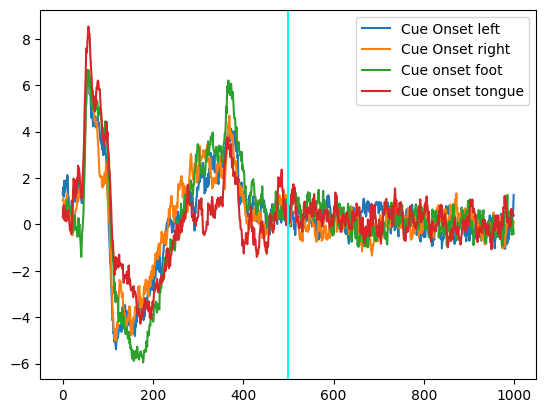

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





## Preprocessing the dataset

In [3]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


## Preparing the training, validation, and test datasets

In [4]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

## Defining the architecture of a basic RNN model

In [35]:
# Building the RNN model using sequential class

# Define the input shape
input_shape = (250, 1, 22)

# Define the model architecture
rnn_model = Sequential()

rnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=input_shape))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

rnn_model.add(Conv2D(filters=75, kernel_size=(10,1), padding='same', activation='elu'))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

rnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

rnn_model.add(Reshape((10, 200))) # Reshape the output from the previous layer
rnn_model.add(LSTM(units=64, dropout=0.6, recurrent_dropout=0.1, return_sequences=False))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

rnn_model.add(Flatten())
rnn_model.add(Dense(4, activation='softmax'))

# rnn_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
# rnn_model.add(Dense((100)))
# rnn_model.add(Reshape((28, 1, 75)))
# rnn_model.add(LSTM(units=64, dropout=0.6, recurrent_dropout=0.1, input_shape=(28, 1, 75), return_sequences=False))
# rnn_model.add(Dense(4, activation='softmax'))


# rnn = tf.keras.models.Sequential([
#     tf.keras.layers.Reshape(target_shape=(250,22), input_shape=input_shape),
#     tf.keras.layers.LSTM(units=64, return_sequences=True),
#     Dropout(0.6),
#     LSTM(units=32, return_sequences=False),
#     Dropout(0.6),
#     tf.keras.layers.Dense(units=4, activation='softmax')
# ])


# Printing the model summary
rnn_model.summary()



Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_41 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_43 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_40 (Conv2D)          (None, 84, 1, 75)         18825     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 28, 1, 75)      

## Defining the hyperparameters of the basic RNN model

In [41]:
# Model parameters
learning_rate = 1e-3
epochs = 60
optimizer = keras.optimizers.Adam(lr=learning_rate)
# TODO: set learning rate decay rate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Compiling, training and validating the model

In [42]:
# Compiling the model
rnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
rnn_results = rnn_model.fit(x_train,
             y_train,
             batch_size=128,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/60
55/55 [==============================] - 11s 122ms/step - loss: 0.8349 - accuracy: 0.6741 - val_loss: 1.0811 - val_accuracy: 0.5740
Epoch 2/60
55/55 [==============================] - 7s 132ms/step - loss: 0.8242 - accuracy: 0.6815 - val_loss: 1.1250 - val_accuracy: 0.5660
Epoch 3/60
55/55 [==============================] - 7s 118ms/step - loss: 0.8163 - accuracy: 0.6878 - val_loss: 1.1218 - val_accuracy: 0.5633
Epoch 4/60
55/55 [==============================] - 7s 132ms/step - loss: 0.8147 - accuracy: 0.6838 - val_loss: 1.0518 - val_accuracy: 0.5913
Epoch 5/60
55/55 [==============================] - 8s 142ms/step - loss: 0.7889 - accuracy: 0.6997 - val_loss: 1.0613 - val_accuracy: 0.5947
Epoch 6/60
55/55 [==============================] - 6s 115ms/step - loss: 0.7831 - accuracy: 0.6991 - val_loss: 1.0794 - val_accuracy: 0.5767
Epoch 7/60
55/55 [==============================] - 8s 145ms/step - loss: 0.7851 - accuracy: 0.6960 - val_loss: 1.0764 - val_accuracy: 0.5820
Epoch

## Visualizing the accuracy and loss trajectory

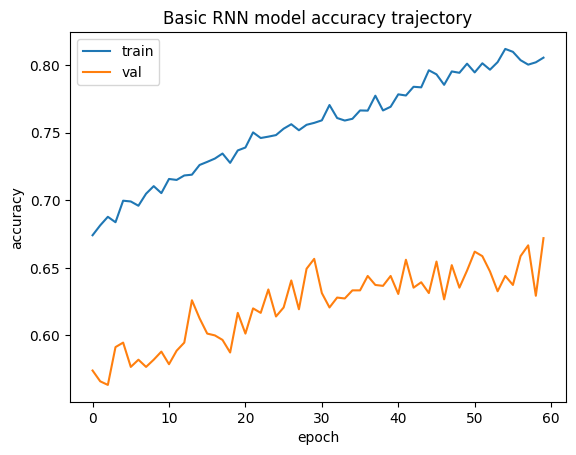

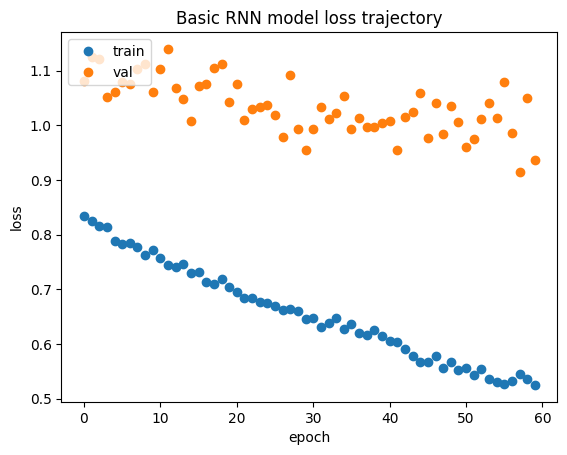

In [43]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(rnn_results.history['accuracy'])
plt.plot(rnn_results.history['val_accuracy'])
plt.title('Basic RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(rnn_results.history['loss'],'o')
plt.plot(rnn_results.history['val_loss'],'o')
plt.title('Basic RNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the performance of the basic RNN model on the held out test set

In [44]:
## Testing the basic RNN model

rnn_score = rnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic RNN model:',rnn_score[1])

Test accuracy of the basic RNN model: 0.6518058776855469
